## Cryptocurrency trading-pair forecasting, using machine learning and deep learning Technique

#### Objectives:
    1. Find the most correlated cryptocurrency to the base Currency (Bitcoin)
    2. Forecast Adjusted price for selected pair using Machine Learning and Deep Learning Models

### 1. Fetching the required data 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import yfinance as yf 
import statsmodels.tsa.stattools as ts 
%matplotlib inline 
from statsmodels.tsa.stattools import coint 
from sklearn.preprocessing import MinMaxScaler 
from keras.layers import Dense, LSTM 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima  
from keras.models import Sequential 
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns 
np.random.seed(0) 

plt.style.use('seaborn-v0_8-darkgrid') 
import warnings 
warnings.filterwarnings('ignore') 

In [3]:
start_date = '2018-01-01'
end_date = '2019-09-01' 

assets = ['BTC-USD','ETH-USD','XRP-USD','BCH-USD','USDT-USD','LTC-USD','EOS-USD','BNB-USD','XLM-USD']

In [4]:
data = pd.DataFrame() 

for ticker in assets:
    tick = ticker.split('-USD')[0]  
    data[f'{tick}_ADJ'] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head() 

,BTC_ADJ,ETH_ADJ,XRP_ADJ,BCH_ADJ,USDT_ADJ,LTC_ADJ,EOS_ADJ,BNB_ADJ,XLM_ADJ
Date,,,,,,,,,
2018-01-01,13657.200195,772.640991,2.39103,2432.540039,1.007280,229.033005,8.84318,8.41461,0.480008
2018-01-02,14982.099609,884.443970,2.48090,2711.000000,1.004900,255.684006,9.33471,8.83777,0.564766
2018-01-03,15201.000000,962.719971,3.10537,2608.689941,1.013440,245.367996,10.22790,9.53588,0.896227
2018-01-04,15599.200195,980.921997,3.19663,2430.179932,1.002530,241.369995,11.27550,9.21399,0.724050
2018-01-05,17429.500000,997.719971,3.04871,2584.479980,0.998634,249.270996,10.83960,14.91720,0.662712


### 2. Visualizing the performance of cryptocurrencies

Normalizing prices by first value

In [6]:
norm_prices = data.divide(data.iloc[0]) 
norm_prices.head() 

,BTC_ADJ,ETH_ADJ,XRP_ADJ,BCH_ADJ,USDT_ADJ,LTC_ADJ,EOS_ADJ,BNB_ADJ,XLM_ADJ
Date,,,,,,,,,
2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-02,1.097011,1.144702,1.037586,1.114473,0.997637,1.116363,1.055583,1.050289,1.176576
2018-01-03,1.113039,1.246012,1.298758,1.072414,1.006116,1.071322,1.156586,1.133253,1.867108
2018-01-04,1.142196,1.269570,1.336926,0.999030,0.995284,1.053866,1.275050,1.094999,1.508412
2018-01-05,1.276213,1.291311,1.275061,1.062461,0.991416,1.088363,1.225758,1.772774,1.380627


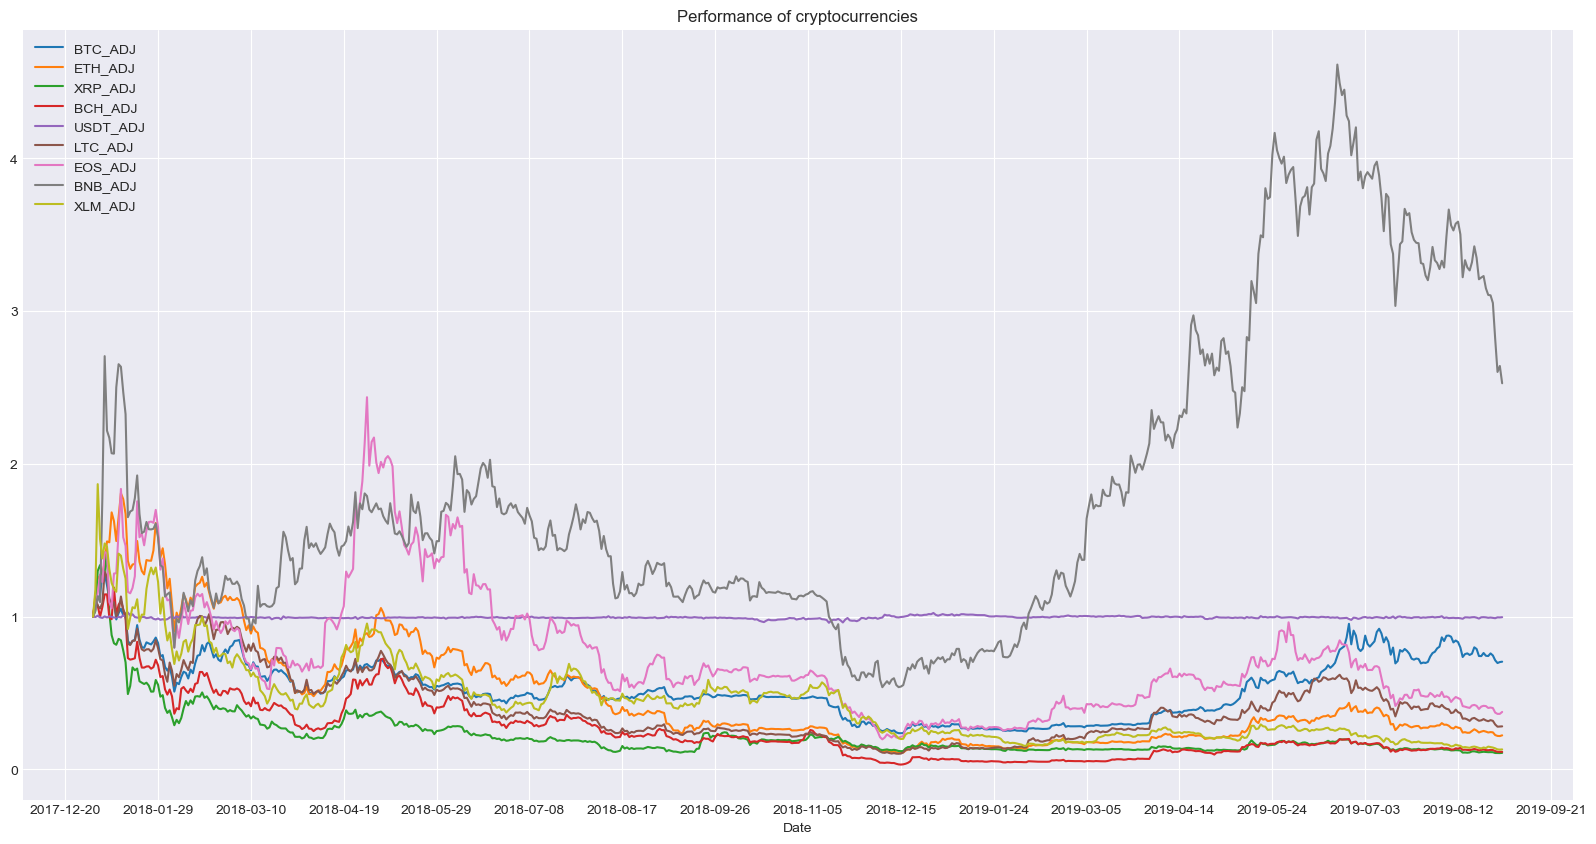

In [7]:
Norm_assets = data.columns 

plt.figure(figsize=(20,10)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(norm_prices) 
plt.title('Performance of cryptocurrencies') 
plt.legend(Norm_assets,loc='best') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.show() 

In the given time interval, some currencies tend to outperform others. 

### 3. Normalizing dataframe (dt) 

In [8]:
def normalize_series(data):
    return data.pct_change(1).dropna() 

dt = normalize_series(data) 
dt = dt.tail(len(dt)-1) 
dt.columns = ['BTC_RET','ETH_RET','XRP_RET','BCH_RET','USDT_RET','LTC_RET','EOS_RET','BNB_RET','XLM_RET'] 
dt.head() 

,BTC_RET,ETH_RET,XRP_RET,BCH_RET,USDT_RET,LTC_RET,EOS_RET,BNB_RET,XLM_RET
Date,,,,,,,,,
2018-01-03,0.014611,0.088503,0.251711,-0.037739,0.008498,-0.040347,0.095685,0.078992,0.586900
2018-01-04,0.026196,0.018907,0.029388,-0.068429,-0.010765,-0.016294,0.102426,-0.033756,-0.192113
2018-01-05,0.117333,0.017125,-0.046274,0.063493,-0.003886,0.032734,-0.038659,0.618973,-0.084715
2018-01-06,0.005594,0.044061,0.014846,0.078225,0.010370,0.189284,0.160532,0.525742,0.071272
2018-01-07,-0.059873,0.107029,0.091740,0.000083,-0.007354,-0.026996,-0.004595,-0.180274,-0.014508


#### 3.1 Normalizing and Calculating cumulative returns (percentage change) for each crypto-currency

In [9]:
def normalize_and_accumulate_series(data):
    return data.pct_change(1).cumsum().dropna() 

dtc = normalize_and_accumulate_series(data) 

dtc = dtc.tail(len(dtc)-1) 
dtc.columns = ['BTC_CRET','ETH_CRET','XRP_CRET','BCH_CRET','USDT_CRET','LTC_CRET','EOS_CRET',
               'BNB_CRET','XLM_CRET'] 
dtc.head() 

,BTC_CRET,ETH_CRET,XRP_CRET,BCH_CRET,USDT_CRET,LTC_CRET,EOS_CRET,BNB_CRET,XLM_CRET
Date,,,,,,,,,
2018-01-03,0.111622,0.233205,0.289297,0.076734,0.006136,0.076016,0.151268,0.129280,0.763476
2018-01-04,0.137818,0.252112,0.318685,0.008305,-0.004630,0.059723,0.253694,0.095525,0.571363
2018-01-05,0.255150,0.269237,0.272411,0.071798,-0.008516,0.092457,0.215034,0.714498,0.486648
2018-01-06,0.260744,0.313298,0.287257,0.150023,0.001854,0.281741,0.375566,1.240240,0.557920
2018-01-07,0.200871,0.420327,0.378997,0.150105,-0.005500,0.254745,0.370972,1.059966,0.543412


#### 3.2 Plotting percentage change

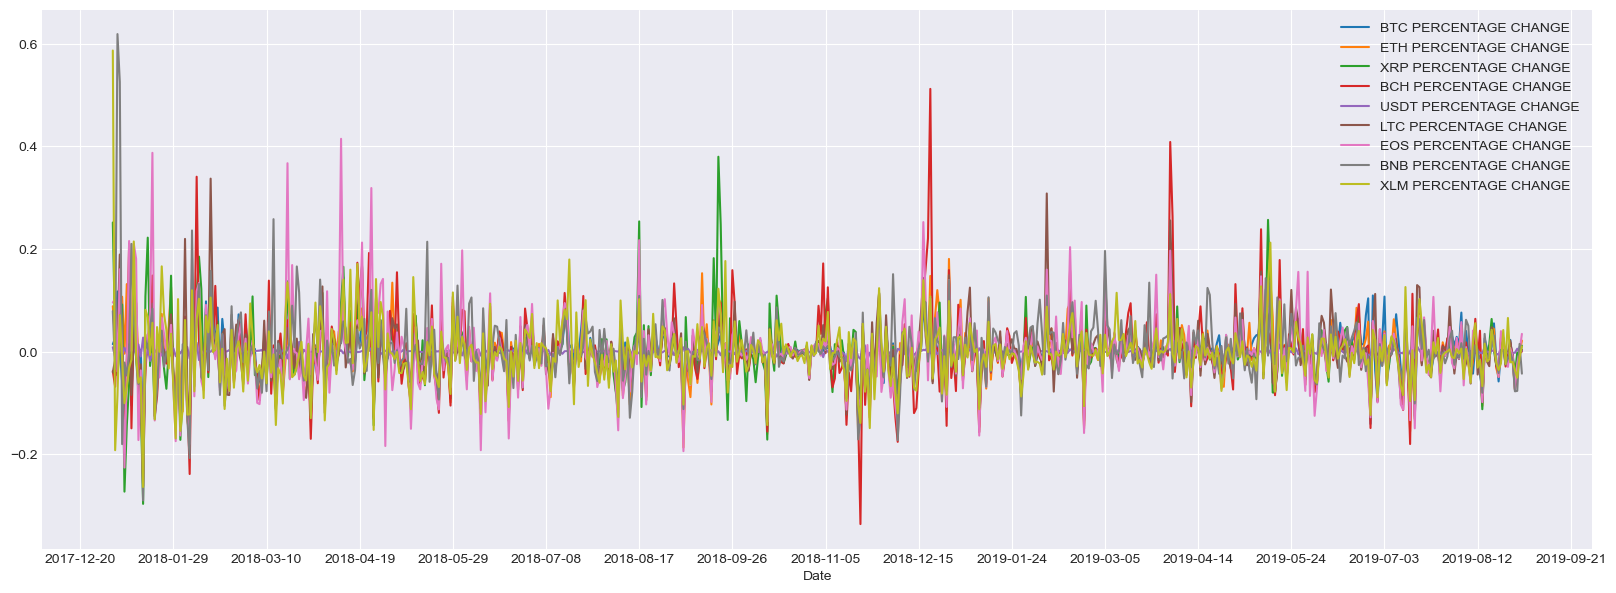

In [10]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
for name in dt.columns:
    tick = name.split('_RET')[0] 
    plt.plot(dt[name], label=f'{tick} PERCENTAGE CHANGE') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()      

#### 3.3 Plotting Cumulative returns

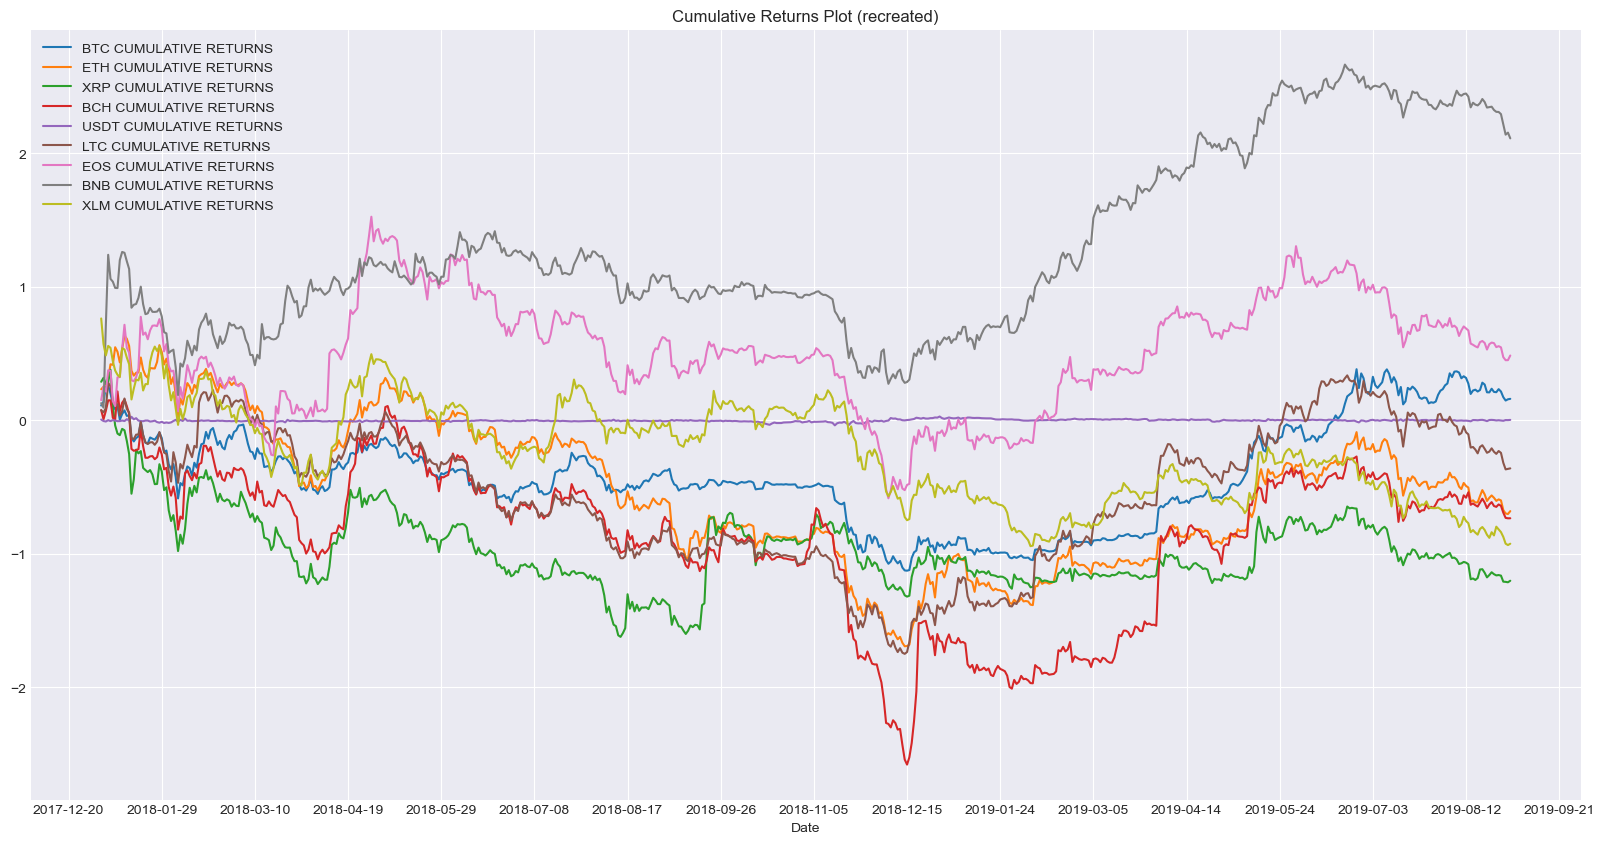

In [11]:
plt.figure(figsize=(20,10)) 
plt.style.use('seaborn-v0_8-dark')  
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
for name in dtc.columns:
    tick = name.split('_CRET')[0] 
    plt.plot(dtc[name], label=f'{tick} CUMULATIVE RETURNS') 
plt.xlabel('Date') 
plt.title('Cumulative Returns Plot (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()      

Criteria for selecting pairs are by examining correlation and cointegration. 
* Pair with highest correlation is desired pair
* Pair should also exhibit significantly low cointegration. A value less than 0.05 is desired 
* Highly positive correlation indicates pairs are moving in the sam edirection

### 4. Calculating P-value for every possible pair (9 cryptocurrencies are selected) 

In [12]:
p_value = [] 
for x in dt.columns:
    for y in dt.columns:
        if x!=y:
            test_result = ts.coint(dt[x],dt[y]) 
            p_value.append(test_result[1])  
            print(x+' and '+y+': p-value = '+str(test_result[1])) 

BTC_RET and ETH_RET: p-value = 0.0
BTC_RET and XRP_RET: p-value = 2.377387750181754e-29
BTC_RET and BCH_RET: p-value = 1.6325415723935115e-24
BTC_RET and USDT_RET: p-value = 1.83873821291063e-23
BTC_RET and LTC_RET: p-value = 7.62794412335389e-28
BTC_RET and EOS_RET: p-value = 8.534936035753194e-23
BTC_RET and BNB_RET: p-value = 0.0
BTC_RET and XLM_RET: p-value = 5.979311587938109e-25
ETH_RET and BTC_RET: p-value = 2.688546505680823e-15
ETH_RET and XRP_RET: p-value = 7.0884375077840764e-15
ETH_RET and BCH_RET: p-value = 2.8781131383029786e-12
ETH_RET and USDT_RET: p-value = 9.068508165948351e-23
ETH_RET and LTC_RET: p-value = 4.083831878068385e-27
ETH_RET and EOS_RET: p-value = 2.1884807763497907e-24
ETH_RET and BNB_RET: p-value = 1.4540299138712235e-14
ETH_RET and XLM_RET: p-value = 1.266188254280906e-22
XRP_RET and BTC_RET: p-value = 2.052586237300488e-29
XRP_RET and ETH_RET: p-value = 0.0
XRP_RET and BCH_RET: p-value = 0.0
XRP_RET and USDT_RET: p-value = 0.0
XRP_RET and LTC_RET: p-v

In [13]:
result = []
for res in p_value:
    if res<0.05:
        result.append(res) 

print(f'Out of {len(p_value)} values, {len(result)} values pass the test') 

Out of 72 values, 72 values pass the test


#### 4.1 Plotting p-values w.r.t 0.05

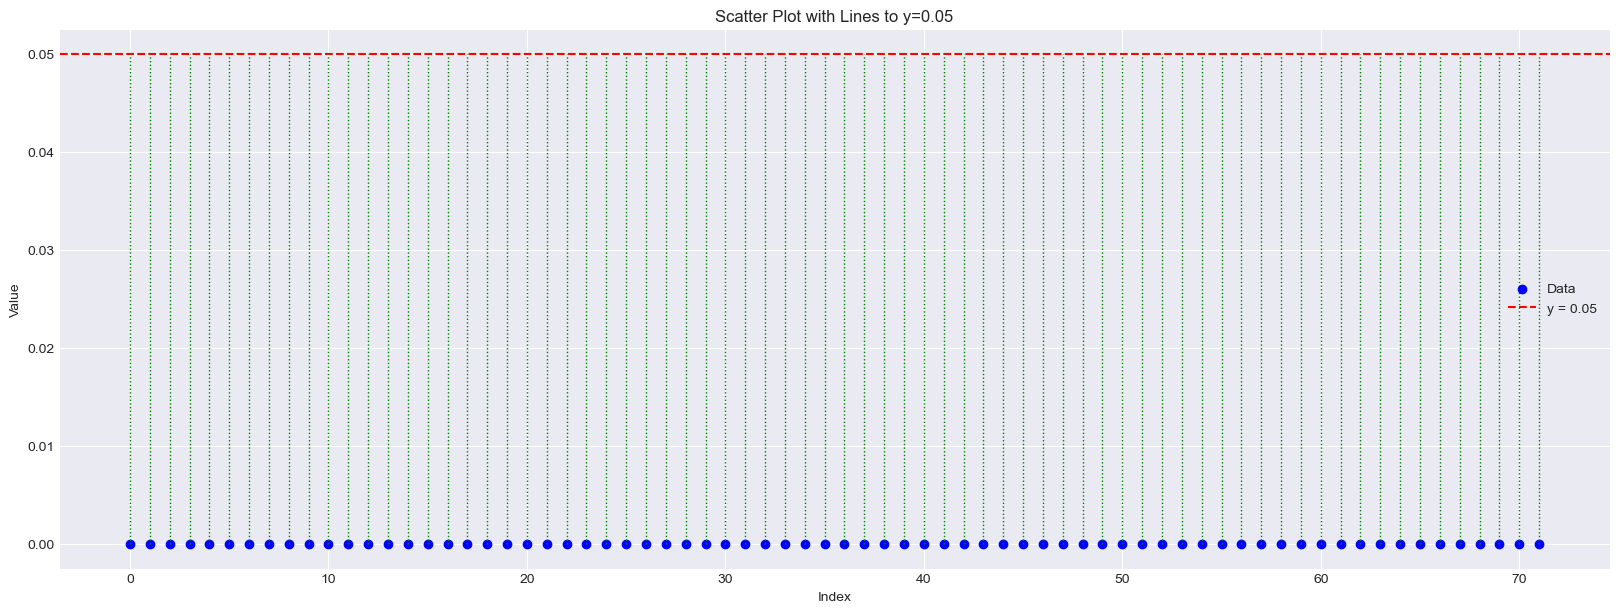

In [14]:
plt.figure(figsize=(20,7)) 
# data = [0.01, 0.02, 0.05, 0.03, 0.06, 0.04, 0.07]
plt.scatter(range(len(p_value)), p_value, label='Data', color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='y = 0.05')
for i, value in enumerate(p_value):
    plt.plot([i, i], [value, 0.05], color='green', linestyle=':', linewidth=1)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot with Lines to y=0.05')
plt.legend()
plt.grid(True)
plt.show()

Here, we can see, p-values of all pairs are less than 0.05. Therefore, we have to do the correlation test

Correlation is defined as the degree to which the pair tend to move together

### 5. Defining Correlation function

In [15]:
def corrltn(data1,data2):
    mean1 = data1.mean() 
    mean2 = data2.mean() 
    std1 = data1.std() 
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2) 
    return corr 

#### 5.1 Implementing Correlation on pair BTC and other cryptocurrencies

In [16]:
co_rrelation = dict() 
stock_name_1 = 'BTC_RET' 
stock_name_2 = ['ETH_RET', 'XRP_RET', 'BCH_RET', 'USDT_RET', 'LTC_RET', 'EOS_RET', 'BNB_RET','XLM_RET']  

for stock in stock_name_2:
    score,pvalue,_ = coint(dt[stock_name_1],dt[stock]) 
    correlation = corrltn(dt[stock_name_1],dt[stock]) 
    st_name = stock.split('_RET')[0] 
    co_rrelation[st_name] = correlation 
    print(f'correlation between {stock_name_1} and {stock} is {correlation:.6f}') 
    print(f'cointegration between {stock_name_1} and {stock} is {pvalue:.6f}')   
    print(' ')    

correlation between BTC_RET and ETH_RET is 0.811601
cointegration between BTC_RET and ETH_RET is 0.000000
 
correlation between BTC_RET and XRP_RET is 0.666299
cointegration between BTC_RET and XRP_RET is 0.000000
 
correlation between BTC_RET and BCH_RET is 0.759461
cointegration between BTC_RET and BCH_RET is 0.000000
 
correlation between BTC_RET and USDT_RET is 0.173986
cointegration between BTC_RET and USDT_RET is 0.000000
 
correlation between BTC_RET and LTC_RET is 0.784705
cointegration between BTC_RET and LTC_RET is 0.000000
 
correlation between BTC_RET and EOS_RET is 0.689638
cointegration between BTC_RET and EOS_RET is 0.000000
 
correlation between BTC_RET and BNB_RET is 0.580083
cointegration between BTC_RET and BNB_RET is 0.000000
 
correlation between BTC_RET and XLM_RET is 0.652003
cointegration between BTC_RET and XLM_RET is 0.000000
 


#### 5.2 Correlation Matrix and Heat Map

In [17]:
corr_matrix = dt.corr() 
dt.corr() 

,BTC_RET,ETH_RET,XRP_RET,BCH_RET,USDT_RET,LTC_RET,EOS_RET,BNB_RET,XLM_RET
BTC_RET,1.000000,0.812942,0.667400,0.760716,0.174274,0.786002,0.690778,0.581042,0.653081
ETH_RET,0.812942,1.000000,0.750235,0.756858,0.103541,0.812240,0.736737,0.555171,0.708853
XRP_RET,0.667400,0.750235,1.000000,0.623467,0.023370,0.678492,0.674875,0.454398,0.745556
BCH_RET,0.760716,0.756858,0.623467,1.000000,0.092518,0.753170,0.670311,0.480798,0.595612
USDT_RET,0.174274,0.103541,0.023370,0.092518,1.000000,0.105778,0.039450,0.089682,0.126550
LTC_RET,0.786002,0.812240,0.678492,0.753170,0.105778,1.000000,0.716406,0.585072,0.629457
EOS_RET,0.690778,0.736737,0.674875,0.670311,0.039450,0.716406,1.000000,0.505097,0.635041
BNB_RET,0.581042,0.555171,0.454398,0.480798,0.089682,0.585072,0.505097,1.000000,0.470893
XLM_RET,0.653081,0.708853,0.745556,0.595612,0.126550,0.629457,0.635041,0.470893,1.000000


<Axes: >

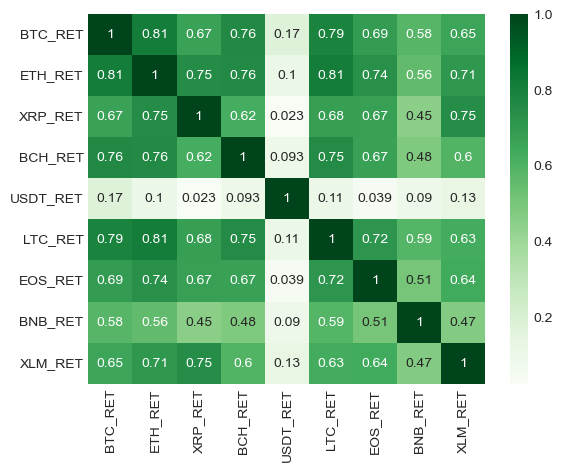

In [18]:
sns.heatmap(corr_matrix, annot=True, cmap='Greens')   

### 6. Selecting Cryptocurrency pair

In [19]:
sorted_co_rrelation = dict(sorted(co_rrelation.items(), key=lambda item:item[1],reverse=True)) 
sorted_co_rrelation 

{'ETH': 0.811600635932039,
 'LTC': 0.7847052793981729,
 'BCH': 0.7594607812756379,
 'EOS': 0.6896380268689986,
 'XRP': 0.6662985622869438,
 'XLM': 0.6520030911647829,
 'BNB': 0.5800827606193579,
 'USDT': 0.1739863937411107}

Here, we can see, Ethereum (ETH) has the best correlation value (81.2%). Thus, the pair we consider is Bitcoin/Ethereum pair.

### 7. Analysing the Selected Pair BTC-ETH

In [20]:
btc = yf.download('BTC-USD',start=start_date,end=end_date) 
eth = yf.download('ETH-USD',start=start_date,end=end_date) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
btc.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [22]:
eth.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824


In [23]:
print('Shape of btc' ,btc.shape)
print('Shape of eth' ,eth.shape)

Shape of btc (608, 6)
Shape of eth (608, 6)


In [24]:
crypto_pair = pd.DataFrame(index=btc.index) 
crypto_pair['Date'] = btc.index 
crypto_pair['BTC_Adj_Close'] = btc['Adj Close'] 
crypto_pair['ETH_Adj_Close'] = eth['Adj Close'] 

In [25]:
crypto_pair.head() 

,Date,BTC_Adj_Close,ETH_Adj_Close
Date,,,
2018-01-01,2018-01-01,13657.200195,772.640991
2018-01-02,2018-01-02,14982.099609,884.443970
2018-01-03,2018-01-03,15201.000000,962.719971
2018-01-04,2018-01-04,15599.200195,980.921997
2018-01-05,2018-01-05,17429.500000,997.719971


#### 7.1 Plotting Adj Close Price of BTC and ETH

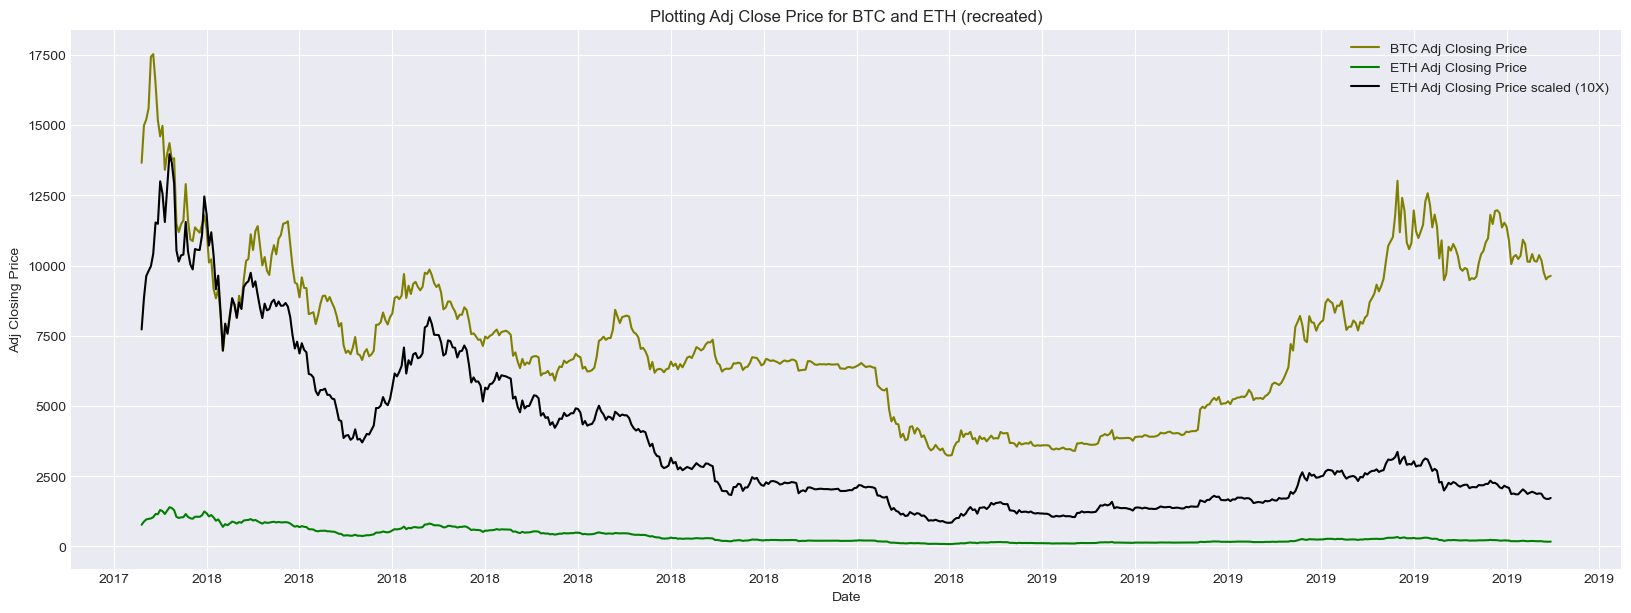

In [26]:
eth_scaling_factor = 10 

plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(crypto_pair['BTC_Adj_Close'],color='olive',label='BTC Adj Closing Price') 
plt.plot(crypto_pair['ETH_Adj_Close'],color='green',label='ETH Adj Closing Price') 
plt.plot(crypto_pair['ETH_Adj_Close']*eth_scaling_factor,color='black',
         label='ETH Adj Closing Price scaled (10X)') 
plt.xlabel('Date') 
plt.ylabel('Adj Closing Price') 
plt.title('Plotting Adj Close Price for BTC and ETH (recreated)')
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### 7.2 Plotting Returns for BTC and ETH

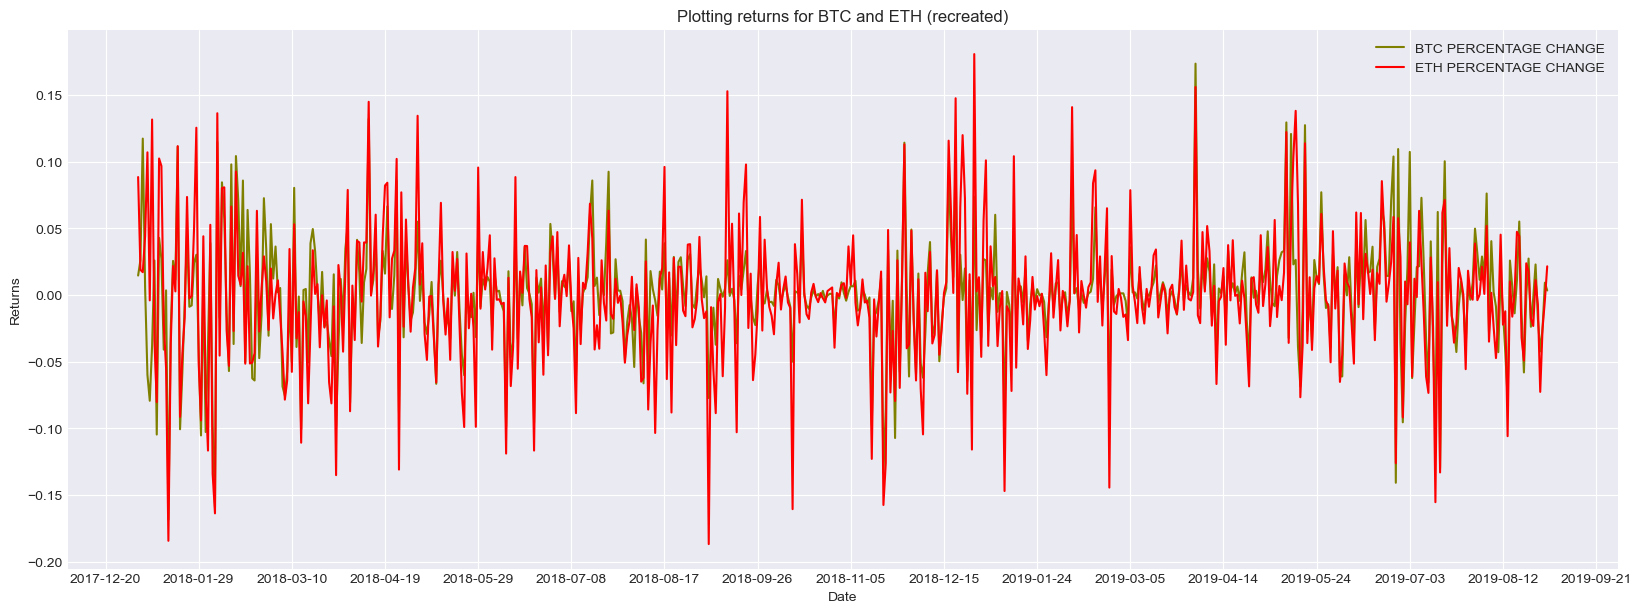

In [27]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(dt['BTC_RET'],color='olive',label='BTC PERCENTAGE CHANGE') 
plt.plot(dt['ETH_RET'],color='red',label='ETH PERCENTAGE CHANGE') 
plt.xlabel('Date') 
plt.ylabel('Returns') 
plt.title('Plotting returns for BTC and ETH (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### 7.3 Plotting cumulative returns of BTC and ETH

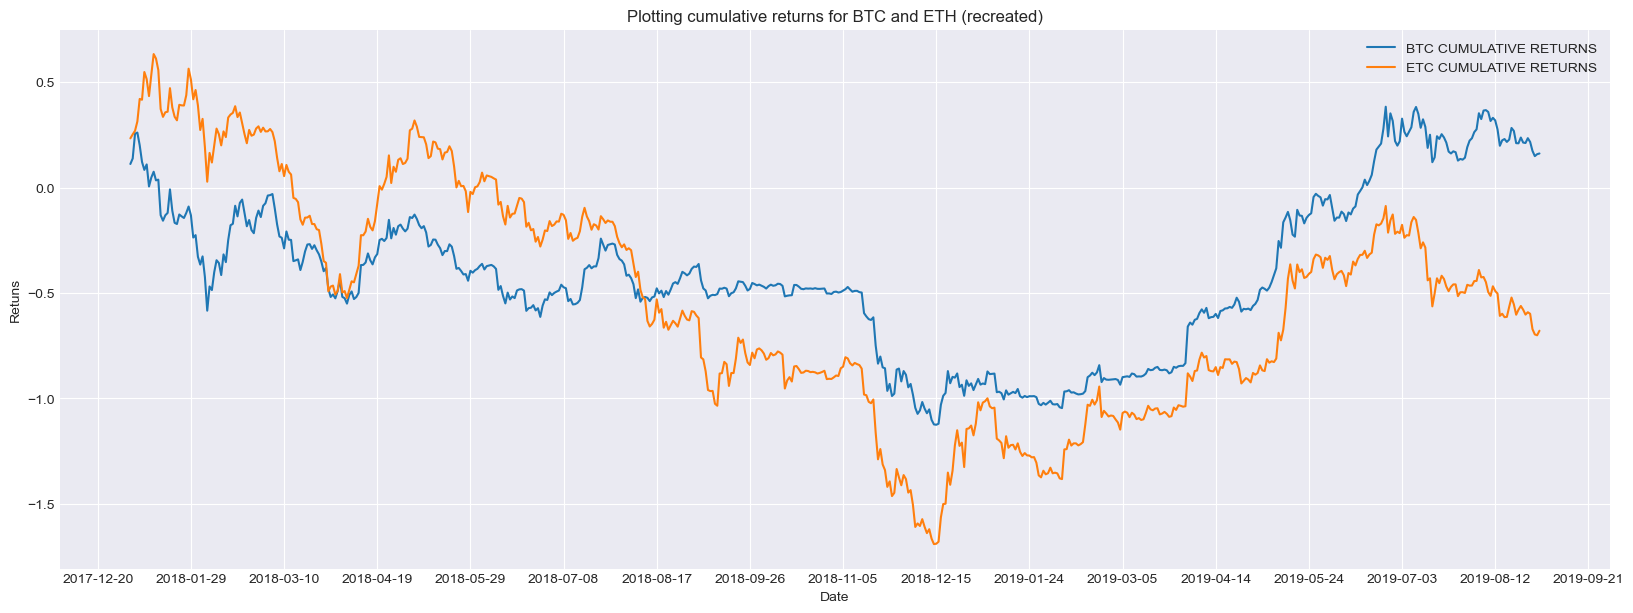

In [28]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(dtc['BTC_CRET'],label='BTC CUMULATIVE RETURNS')
plt.plot(dtc['ETH_CRET'],label='ETC CUMULATIVE RETURNS')
plt.xlabel('Date') 
plt.ylabel('Retuns') 
plt.title('Plotting cumulative returns for BTC and ETH (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### 7.4 Calculating spread of BTC-ETH Pair

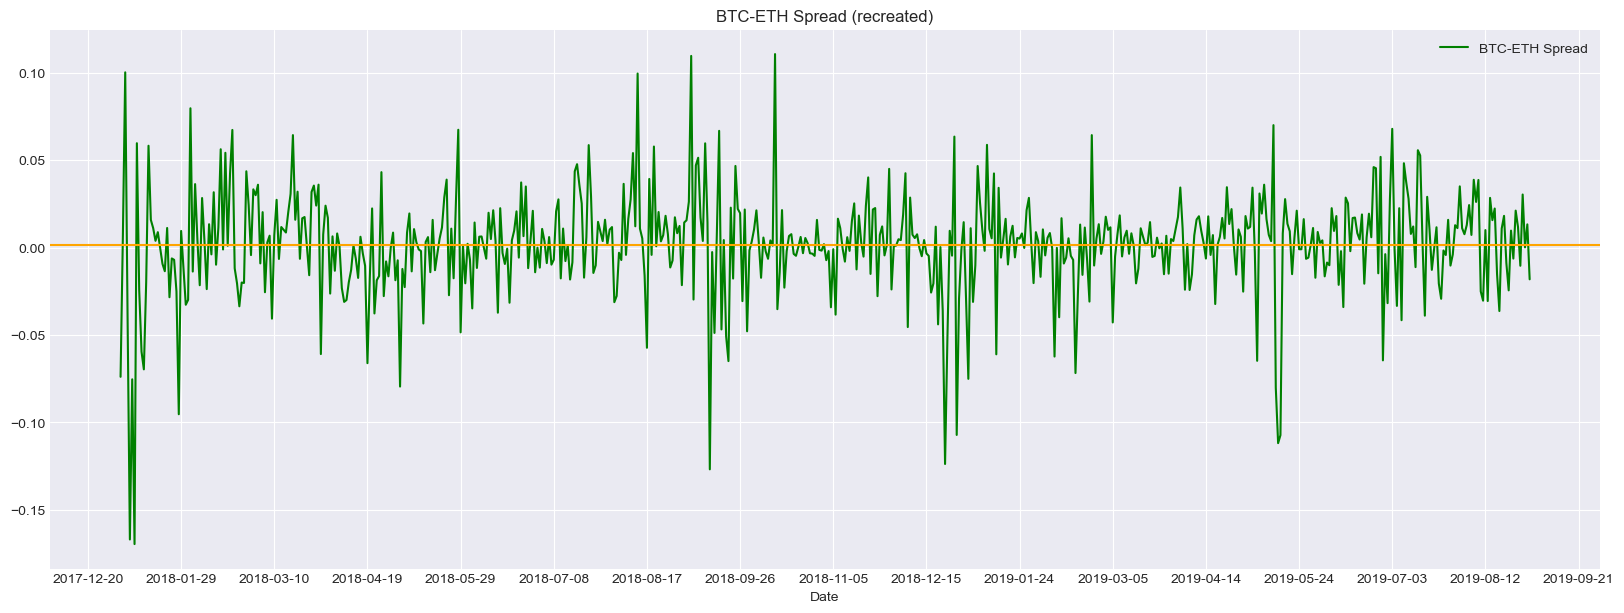

In [29]:
BTC_ETH = dt['BTC_RET']-dt['ETH_RET'] 

plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(BTC_ETH, color='green', label='BTC-ETH Spread') 
plt.title('BTC-ETH Spread (recreated)') 
ax.axhline(BTC_ETH.mean(),color='orange') 
ax.grid(True) 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.legend(loc='best') 
plt.show() 

## 8. Selecting the Model

#### 8.1 Fetching data

In [30]:
btc_adjClose = pd.DataFrame() 
eth_adjClose = pd.DataFrame() 

btc_adjClose['Adj_Close'] = yf.download('BTC-USD',start=start_date,end=end_date)['Adj Close'] 
eth_adjClose['Adj_Close'] = yf.download('ETH-USD',start=start_date,end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [31]:
btc_adjClose.head() 

,Adj_Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


In [32]:
eth_adjClose.head() 

,Adj_Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971


#### 8.2 Splitting data into training and testing dataset

In [33]:
print(f'Size of train dataset : {int(len(btc_adjClose)*0.80)}') 
print(f'Size of test dataset : {len(btc_adjClose)-int(len(btc_adjClose)*0.80)}') 

Size of train dataset : 486
Size of test dataset : 122


In [34]:
btc_train = btc_adjClose[:487] 
btc_test = btc_adjClose[486:] 

print(f'Shape of train after splitting : {btc_train.shape}') 
print(f'Shape of test after splitting : {btc_test.shape}') 

Shape of train after splitting : (487, 1)
Shape of test after splitting : (122, 1)


#### 8.3 Plotting data of training and testing dataset

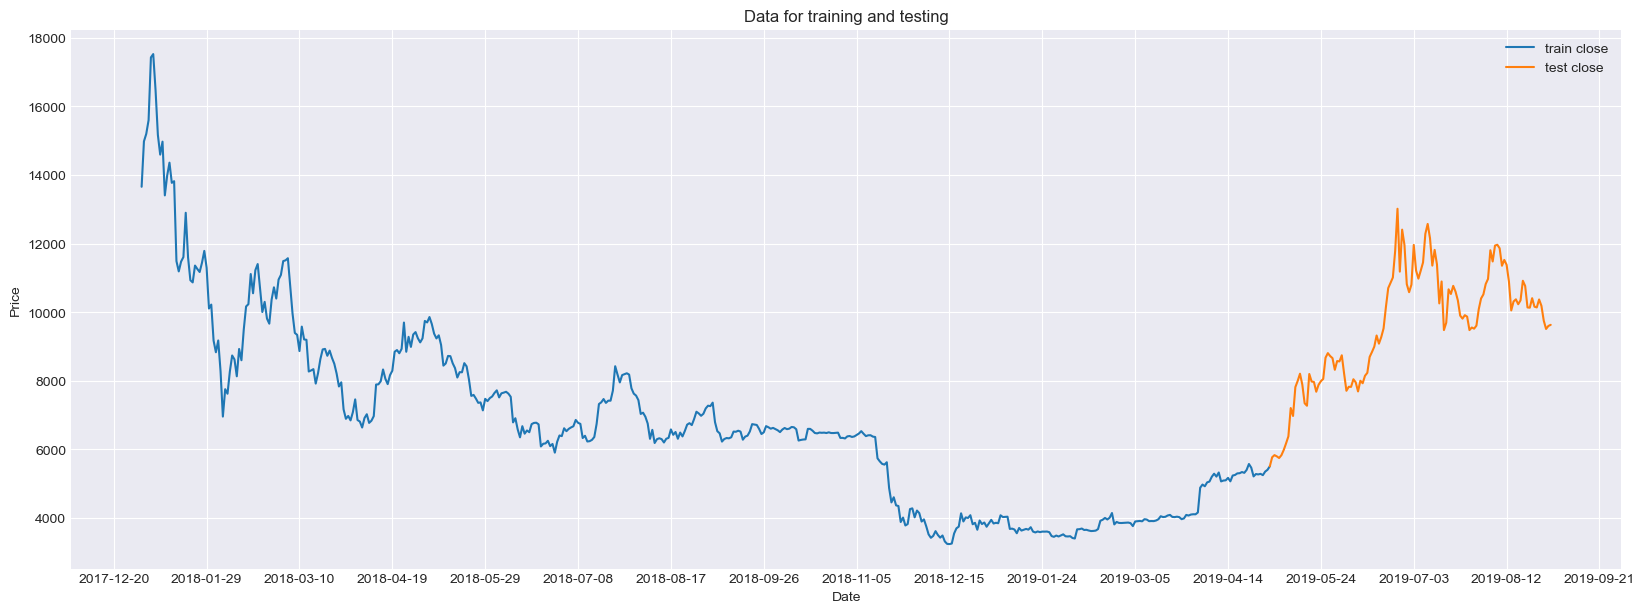

In [35]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='train close') 
plt.plot(btc_test['Adj_Close'],label='test close') 

plt.title('Data for training and testing') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

#### 8.4 Scaling the data for training and testing

In [36]:
np.random.seed(0) 
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(btc_adjClose)     

### Models used are 
1. LSTM
2. Moving Average
3. ARIMA
4. ANN

## 8-A. Long Short-term Memory

#### A.1 Reshaping the scaled data for LSTM Network

In [37]:
x_train, y_train = [],[] 
for i in range(80,len(btc_train)):
    x_train.append(scaled_data[i-80:i,0]) 
    y_train.append(scaled_data[i,0]) 
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape 

(407, 80, 1)

#### A.2 Defining and fitting LSTM Network

In [38]:
model = Sequential() 
model.add(LSTM(units=13,return_sequences=True,input_shape=(x_train.shape[1],1))) 
model.add(LSTM(units=3)) 
model.add(Dense(1)) 
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 13)         │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 988 (3.86 KB)

 Trainable params: 988 (3.86 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy']) 
model.fit(x_train,y_train,epochs=13,batch_size=1,verbose=2) 

Epoch 1/13
407/407 - 10s - 24ms/step - accuracy: 0.0025 - loss: 0.0053
Epoch 2/13
407/407 - 6s - 16ms/step - accuracy: 0.0025 - loss: 0.0014
Epoch 3/13
407/407 - 6s - 16ms/step - accuracy: 0.0025 - loss: 0.0011
Epoch 4/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 0.0010
Epoch 5/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 9.2321e-04
Epoch 6/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 7.5431e-04
Epoch 7/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 7.2985e-04
Epoch 8/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 6.3442e-04
Epoch 9/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 5.8521e-04
Epoch 10/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 5.7959e-04
Epoch 11/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 5.0333e-04
Epoch 12/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 4.7161e-04
Epoch 13/13
407/407 - 6s - 15ms/step - accuracy: 0.0025 - loss: 4.6642e-04


#### A.3 Prediction using the trained LSTM model

Calculating the index from which data is to be taken. This calculation returns the last [len(btc_test)+80] datapoints from the dataset btc_adjClose. reshape is used to reshape the input array to have one column and appropriate number of rows. Scaler expects a 2-D array of format [n_samples,n_features]. These inputs are transformed by MinMax scaler that transforms the values to a range of [0,1] to ensure that the data used for prediction is in the same format as that of data used for training 

In [40]:
indice = len(btc_adjClose)-len(btc_test)-80   
inputs = btc_adjClose[indice:].values 
inputs = inputs.reshape(-1,1) 
inputs = scaler.transform(inputs) 
print(inputs.shape, btc_test.shape)  

(202, 1) (122, 1)


In [41]:
x_test = [] 
for i in range(80,inputs.shape[0]):
    x_test.append(inputs[i-80:i,0]) 
x_test = np.array(x_test) 
print(f'Shape of x_test: ',x_test.shape) 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) 
print(f'Shape of x_test for LSTM: ',x_test.shape) 
close_price_predicted = model.predict(x_test) 
close_price_predicted = scaler.inverse_transform(close_price_predicted)  

Shape of x_test:  (122, 80)
Shape of x_test for LSTM:  (122, 80, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


#### A.4 Evaluating the predictions 

In [42]:
# RMSE for LSTM
rmse_lstm = np.sqrt(np.mean(np.power((btc_test['Adj_Close'].values-close_price_predicted),2)))
print(f'RMSE for LSTM : {rmse_lstm:.6f}') 

# MAPE for LSTM
mape_lstm = np.mean(np.abs(close_price_predicted-btc_test['Adj_Close'].values)/np.abs(btc_test['Adj_Close'].values)) 
print(f'MAPE for LSTM : {mape_lstm:.6f}') 

# MPE for LSTM 
mpe_lstm = np.mean((close_price_predicted-btc_test['Adj_Close'].values)/btc_test['Adj_Close'].values) 
print(f'MPE for LSTM : {mpe_lstm:.6f}')   

RMSE for LSTM : 2394.725847
MAPE for LSTM : 0.212185
MPE for LSTM : -0.000430


#### A.5 Correlation between actual values and predicted via LSTM

In [43]:
btc_test['LSTM_Predictions'] = close_price_predicted 

corr_LSTM = np.corrcoef(btc_test['LSTM_Predictions'].dropna().values,btc_test['Adj_Close'].dropna().values)[0,1] 
corr_LSTM = round(corr_LSTM*100,2) 
print(f'correlation btw test-closing and LSTM-predicted-closing : {corr_LSTM}%')  

correlation btw test-closing and LSTM-predicted-closing : 95.34%


#### A.6 Plotting the predictions from LSTM w.r.t Test values

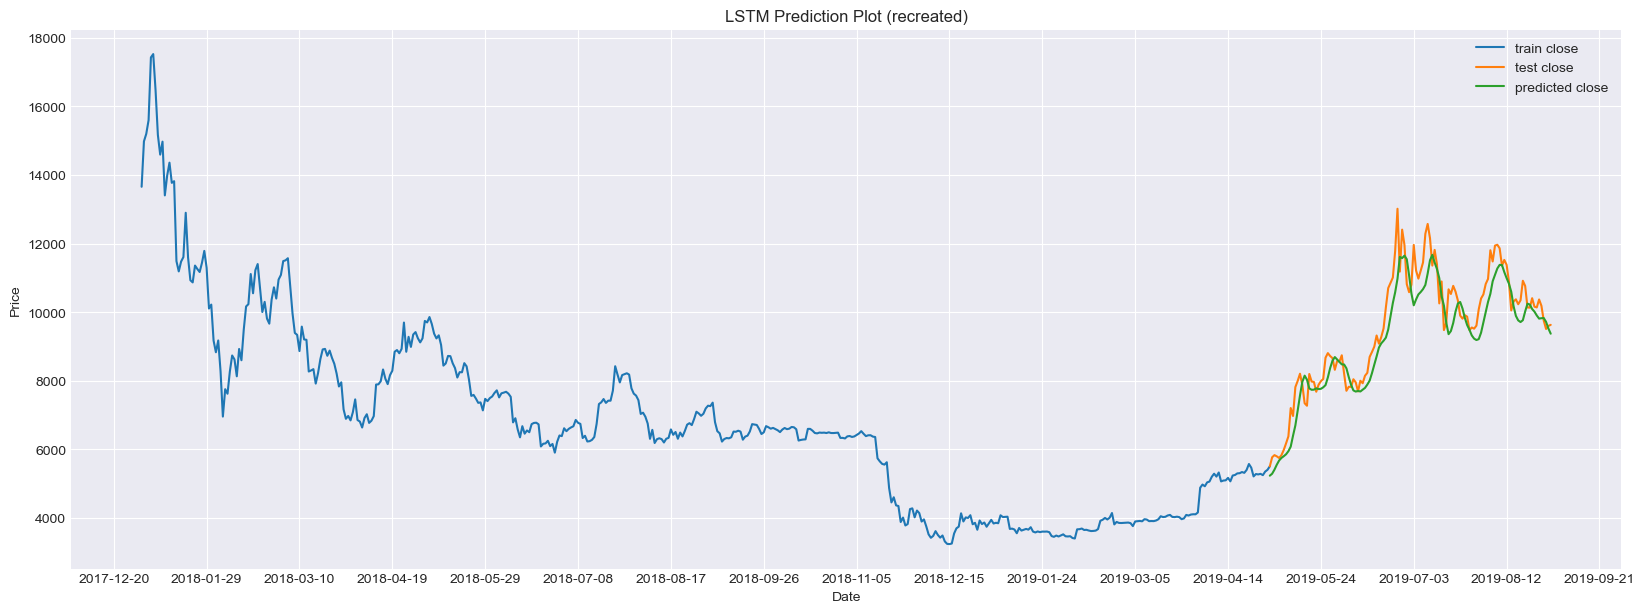

In [44]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='train close') 
plt.plot(btc_test['Adj_Close'],label='test close') 
plt.plot(btc_test['LSTM_Predictions'],label='predicted close') 
plt.title('LSTM Prediction Plot (recreated)') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

## 8-B. Moving Average

#### B.1 Defining MA Model and Predicting using MA

In [45]:
preds = [] 
for i in range(0,btc_test.shape[0]):
    a = btc_train['Adj_Close'][len(btc_train)-122+i:].sum()+sum(preds) 
    b = a/122
    preds.append(b) 

#### B.2 Evaluating the predictions

In [46]:
# RMSE for moving average model 
rmse_ma = np.sqrt(np.mean(np.power((np.array(btc_test['Adj_Close'])-preds),2))) 
print(f'RMSE for MA : {rmse_ma:.6f}') 

# MAPE for moving average model
mape_ma = np.mean(np.abs(preds-btc_test['Adj_Close'].values)/np.abs(btc_test['Adj_Close'].values)) 
print(f'MAPE for MA : {mape_ma:.6f}') 

# MPE for moving average model
mpe_ma = np.mean((preds-btc_test['Adj_Close'].values)/btc_test['Adj_Close'].values)
print(f'MPE for MA : {mpe_ma:.6f}')  

RMSE for MA : 5384.391273
MAPE for MA : 0.522660
MPE for MA : -0.522660


#### B.3. Correlation between actual values and predicted via Moving Average

In [47]:
btc_test['MA_Predictions'] = preds 

corr_MA = np.corrcoef(btc_test['MA_Predictions'].dropna().values,btc_test['Adj_Close'].dropna().values)[0,1]
corr_MA = round(corr_MA*100,2)
print(f'Correlation between test_BTC_close and Moving Average : {corr_MA}%') 

Correlation between test_BTC_close and Moving Average : 83.05%


#### B.4 Plotting the predictions from MA w.r.t Test values

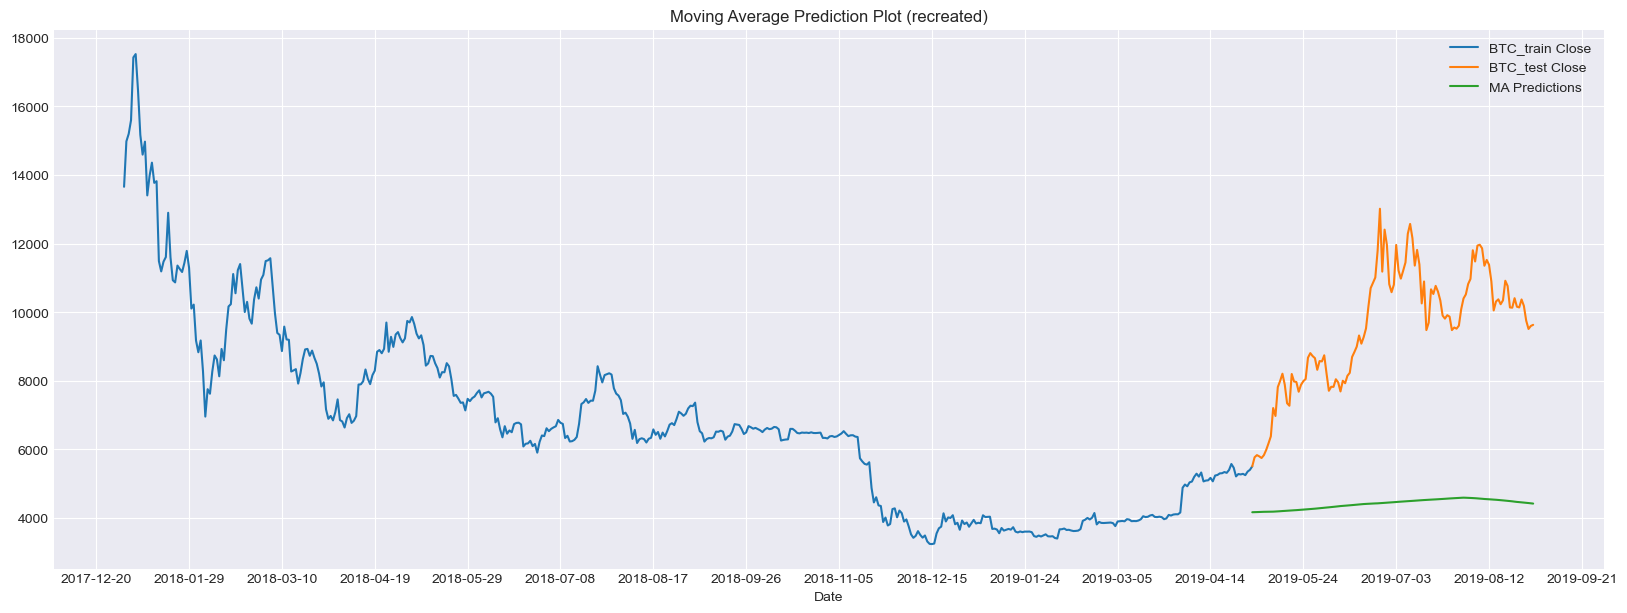

In [48]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='BTC_train Close') 
plt.plot(btc_test['Adj_Close'],label='BTC_test Close') 
plt.plot(btc_test['MA_Predictions'],label='MA Predictions') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xlabel('Date') 
plt.title('Moving Average Prediction Plot (recreated)')
ax.grid(True) 
plt.legend(loc='best')
plt.show()  

## 8-C. ARIMA

#### C.1 ACF and PACF for BITCOIN Returns

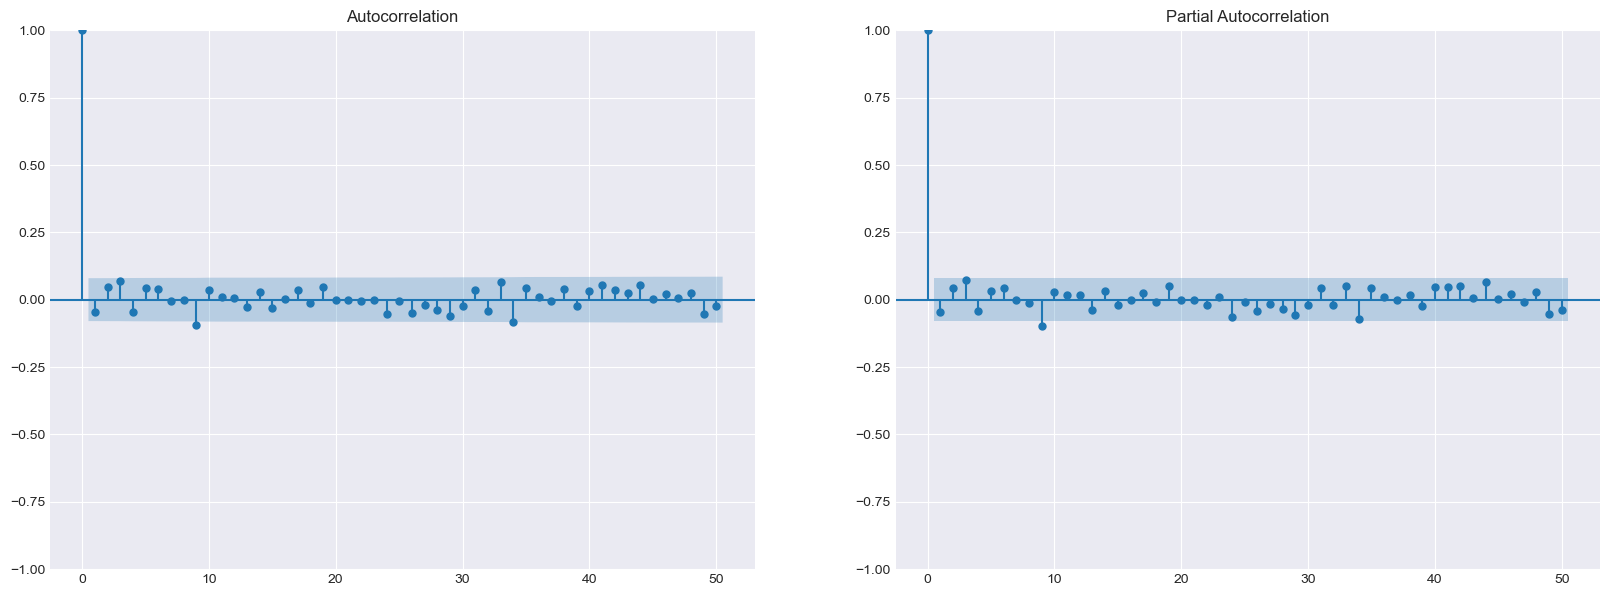

In [49]:
btc_adjClose['Returns'] = btc_adjClose['Adj_Close'].pct_change(1)
btc_adjClose.dropna(inplace=True)

fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(btc_adjClose['Returns'], lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(btc_adjClose['Returns'], lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

#### C.2 ACF and PACF for Squared BITCOIN Returns

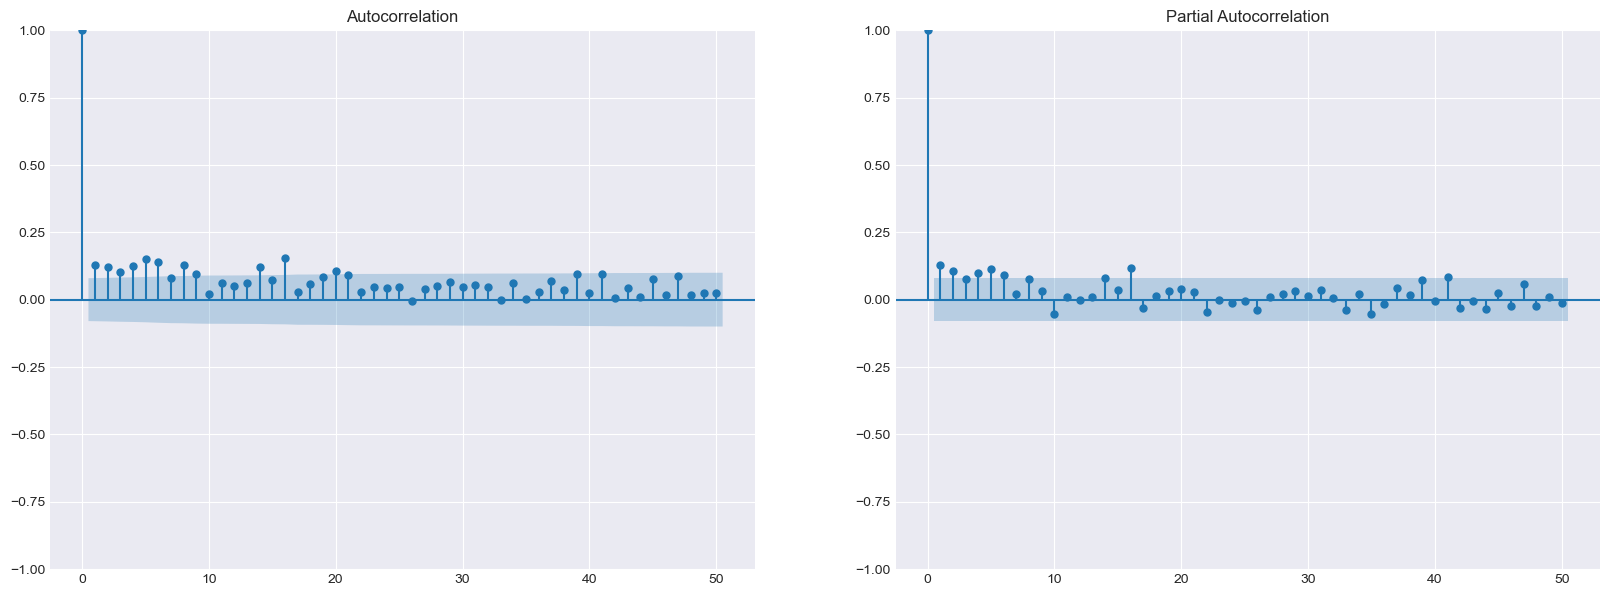

In [50]:
BTC_RET_SQ = btc_adjClose['Returns']**2 

fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(BTC_RET_SQ, lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(BTC_RET_SQ, lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

#### C.3 Defining ARIMA Model

In [51]:
B_model = auto_arima(btc_train,start_p=0,start_q=0,max_p=3,max_q=3,m=12,start_P=0,
                     seasonal=True,d=1,D=1,trace=True,error_action='ignore',suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7193.321, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7064.577, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7192.134, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6989.663, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6989.503, Time=0.59 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7064.895, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6989.795, Time=0.65 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=3.98 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=6991.460, T

In [52]:
B_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  487
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -3491.752
Date:                            Sun, 04 Aug 2024   AIC                           6989.503
Time:                                    17:13:53   BIC                           7001.987
Sample:                                01-01-2018   HQIC                          6994.413
                                     - 05-02-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7239      0.024    -30.523      0.000      -0.770      -0.677
ar.S.L24      -0.4544      0.025    -18.460      0.000      -0.503      -0.406
sigma2      1.417e+05   5037.111     28.125      0.000    1.32e+05    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               806.29
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### C.4 Training the Model

In [53]:
B_model.fit(btc_train)  

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

#### C.5 Predictions using trained model

In [54]:
forecast = B_model.predict(n_periods=122) 
forecast = pd.DataFrame(forecast,index=btc_test.index,columns=['ARIMA_Predictions'])  

#### C.6. Evaluating the predictions

In [55]:
# btc_test = btc_test.to_frame() 
btc_arima = forecast.join(btc_test) 
btc_arima.dropna(inplace=True)  

In [56]:
# RMSE for ARIMA 
rmse_arima = np.sqrt(np.mean(np.power((np.array(btc_arima['Adj_Close'])-np.array(btc_arima['ARIMA_Predictions'])),2))) 
print(f'RMSE for ARIMA : {rmse_arima:.6f}')  

# MAPE for ARIMA 
mape_arima = np.mean(np.abs(btc_arima['ARIMA_Predictions']-btc_arima['Adj_Close'])/np.abs(btc_arima['Adj_Close'])) 
print(f'MAPE for ARIMA : {mape_arima:.6f}')  

# MPE for ARIMA
mpe_arima = np.mean((btc_arima['ARIMA_Predictions'].dropna().values-btc_arima['Adj_Close'].dropna().values)/btc_arima['Adj_Close'].dropna().values) 
print(f'MPE for ARIMA : {mpe_arima:.6f}') 

RMSE for ARIMA : 2550.483250
MAPE for ARIMA : 0.223989
MPE for ARIMA : -0.223989


#### C.7 Correlation between actual values and predicted via ARIMA

In [57]:
corr_ARIMA = np.corrcoef(btc_arima['ARIMA_Predictions'].dropna().values,btc_arima['Adj_Close'].dropna().values)[0,1] 
corr_ARIMA = round(corr_ARIMA*100,2) 
print(f'Correlation between test_Close and ARIMA Predictions : {corr_ARIMA}%')   

Correlation between test_Close and ARIMA Predictions : 72.18%


#### C.8 Plotting the predictions from ARIMA w.r.t Test values 

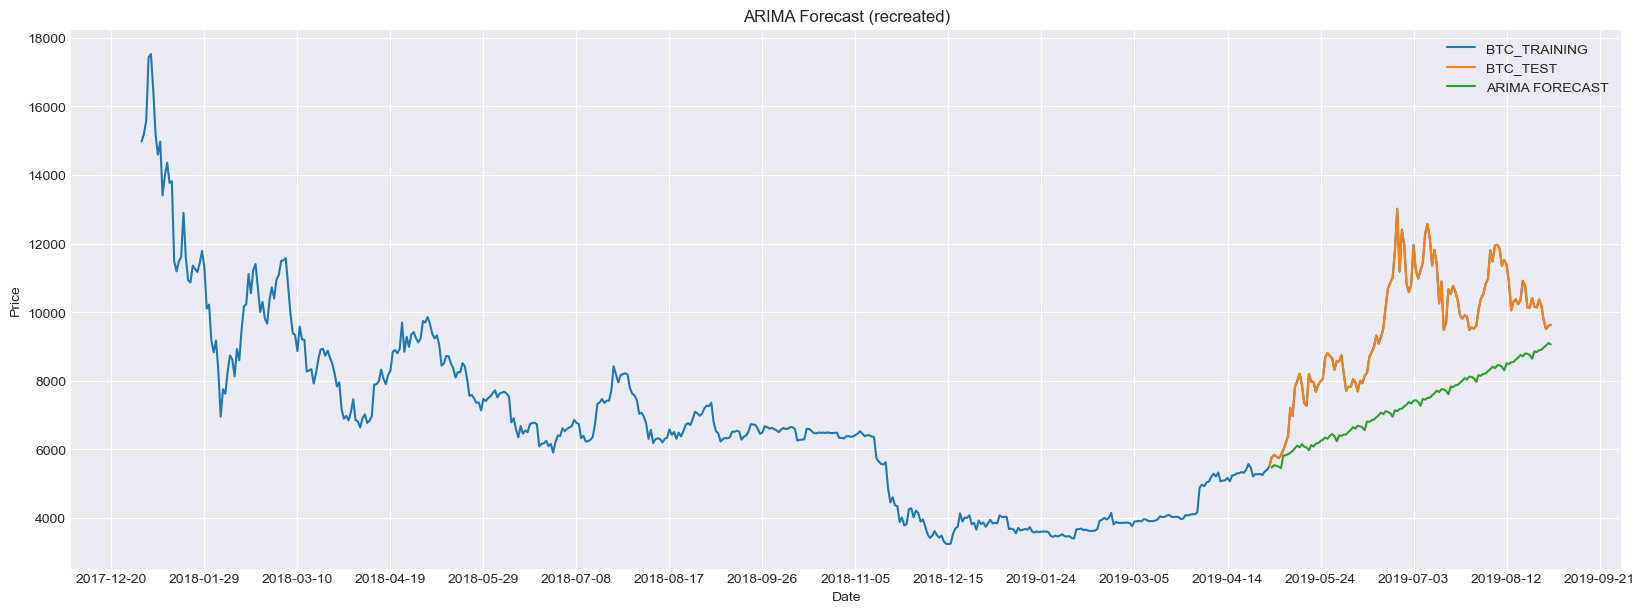

In [58]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_adjClose['Adj_Close'],label='BTC_TRAINING') 
plt.plot(btc_test['Adj_Close'],label='BTC_TEST') 
plt.plot(btc_arima['ARIMA_Predictions'],label='ARIMA FORECAST') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.title('ARIMA Forecast (recreated)') 
plt.ylabel('Price') 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

## 8.D - ANN

#### D.1 Reshaping the scaled data for ANN Network

In [59]:
x_train, y_train = [],[] 
for i in range(80,len(btc_train)):
    x_train.append(scaled_data[i-80:i,0]) 
    y_train.append(scaled_data[i,0]) 
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1])) 
print('Shape of x_train: ',x_train.shape)
print('Shape of y_train: ',y_train.shape)  

Shape of x_train:  (407, 80)
Shape of y_train:  (407,)


#### D.2 Defining ANN Network

In [60]:
model = Sequential() 
model.add(Dense(units=13,kernel_initializer='uniform',activation='relu',input_dim=80)) 
model.add(Dense(units=13,kernel_initializer='uniform',activation='relu')) 
model.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid')) 
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])  
model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 13)             │         1,053 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

#### D.3 Training the model

In [61]:
model.fit(x_train,y_train,batch_size=1,epochs=13,verbose=2)  

Epoch 1/13
407/407 - 2s - 4ms/step - accuracy: 0.0025 - loss: 0.0540
Epoch 2/13
407/407 - 0s - 753us/step - accuracy: 0.0025 - loss: 0.0279
Epoch 3/13
407/407 - 0s - 744us/step - accuracy: 0.0025 - loss: 0.0095
Epoch 4/13
407/407 - 0s - 751us/step - accuracy: 0.0025 - loss: 0.0035
Epoch 5/13
407/407 - 0s - 746us/step - accuracy: 0.0025 - loss: 0.0024
Epoch 6/13
407/407 - 0s - 751us/step - accuracy: 0.0025 - loss: 0.0018
Epoch 7/13
407/407 - 0s - 750us/step - accuracy: 0.0025 - loss: 0.0015
Epoch 8/13
407/407 - 0s - 752us/step - accuracy: 0.0025 - loss: 0.0011
Epoch 9/13
407/407 - 0s - 847us/step - accuracy: 0.0025 - loss: 9.6021e-04
Epoch 10/13
407/407 - 0s - 967us/step - accuracy: 0.0025 - loss: 8.6674e-04
Epoch 11/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 7.6049e-04
Epoch 12/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 7.4585e-04
Epoch 13/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 6.3727e-04


#### D.4 Prediction using Trained ANN Model

In [62]:
btc_ann = pd.DataFrame(index=btc_adjClose.index) 
btc_ann = btc_adjClose['Adj_Close']
inputsB = btc_ann[len(btc_ann)-len(btc_test)-80:].values 
inputsB = inputsB.reshape(-1,1) 
inputsB = scaler.transform(inputsB) 

In [63]:
len(inputsB) 

202

In [64]:
x_test = []
for i in range(80,inputsB.shape[0]):
    x_test.append(inputsB[i-80:i,0]) 
x_test = np.array(x_test) 
print('Before: ',x_test.shape) 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1])) 
print('After: ',x_test.shape) 
closing_price_2 = model.predict(x_test) 
closing_price_2 = scaler.inverse_transform(closing_price_2)     

Before:  (122, 80)
After:  (122, 80)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


#### D.5 Evaluating the Predictions

In [65]:
# RMSE for ANN
rmse_ann = np.sqrt(np.mean(np.power((btc_test['Adj_Close'].values-closing_price_2),2))) 
print(f'RMSE for ANN : {rmse_ann:.6f}') 

# MAPE for ANN 
mape_ann = np.mean(np.abs(closing_price_2-btc_test['Adj_Close'].values)/np.abs(btc_test['Adj_Close'].values)) 
print(f'MAPE for ANN : {mape_ann:.6f}') 

# MPE for ANN 
mpe_ann = np.mean((closing_price_2-btc_test['Adj_Close'].values)/btc_test['Adj_Close'].values) 
print(f'MPE for ANN : {mpe_ann:.6f}') 

RMSE for ANN : 2469.081378
MAPE for ANN : 0.209266
MPE for ANN : -0.111010


#### D.6 Correlation between actual values and predicted via ANN

In [66]:
btc_test['ANN_Predictions'] = closing_price_2 

corr_ANN = np.corrcoef(btc_test['ANN_Predictions'].dropna().values, btc_test['Adj_Close'].dropna().values)[0,1] 
corr_ANN = round(corr_ANN*100,2) 
print(f'Correlation between ANN and actual values : {corr_ANN}%')  

Correlation between ANN and actual values : 90.73%


#### D.7 Plotting the predictions from ANN w.r.t Test values

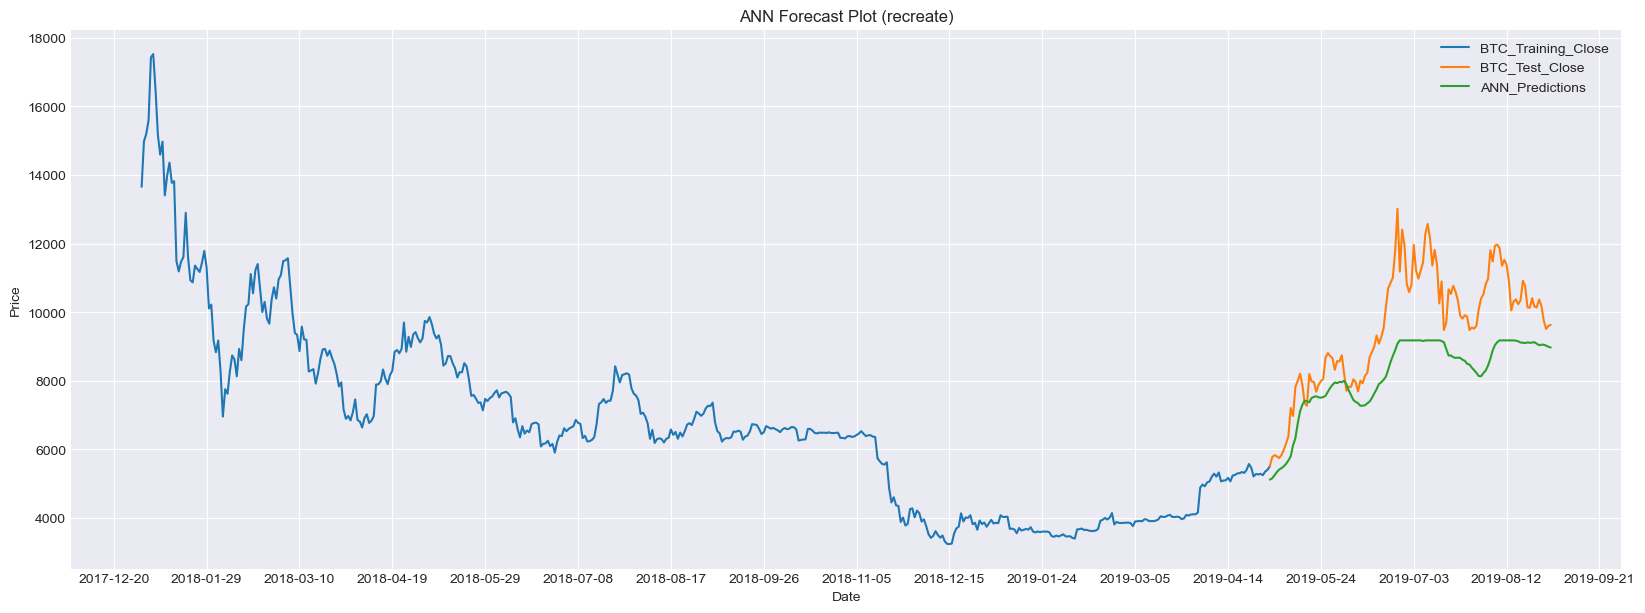

In [67]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_train['Adj_Close'],label='BTC_Training_Close')
plt.plot(btc_test['Adj_Close'],label='BTC_Test_Close')
plt.plot(btc_test['ANN_Predictions'],label='ANN_Predictions') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.ylabel('Price') 
plt.title('ANN Forecast Plot (recreate)') 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

In [68]:
rmse = [rmse_lstm,rmse_ma,rmse_arima,rmse_ann] 
mape = [mape_lstm,mape_ma,mape_arima,mape_ann] 
mpe = [mpe_lstm,mpe_ma,mpe_arima,mpe_ann] 
correln = [corr_LSTM,corr_MA,corr_ARIMA,corr_ANN] 

model_list = ['LSTM','MA','ARIMA','ANN'] 
data={'model':model_list,'rmse':rmse,'mape':mape,'mpe':mpe,'accuracy (%)':correln} 

df_eval = pd.DataFrame(data) 
df_eval 

,model,rmse,mape,mpe,accuracy (%)
0,LSTM,2394.725847,0.212185,-0.000430,95.34
1,MA,5384.391273,0.522660,-0.522660,83.05
2,ARIMA,2550.483250,0.223989,-0.223989,72.18
3,ANN,2469.081378,0.209266,-0.111010,90.73


From the above analysis, we can see that the best performing model is LSTM. Now, we use LSTM for the Second Currrency in the pair - Ethereum, ETH

## 9. LSTM for ETH 

#### 9.1 Splitting data into training and testing dataset

In [69]:
eth_adjClose.head() 

,Adj_Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971


In [70]:
print(f'Size of train dataset : {int(len(eth_adjClose)*0.80)}') 
print(f'Size of test dataset : {len(eth_adjClose)-int(len(eth_adjClose)*0.80)}') 

Size of train dataset : 486
Size of test dataset : 122


In [71]:
eth_train = eth_adjClose[:487] 
eth_test = eth_adjClose[486:] 

print(f'Shape of train after splitting : {eth_train.shape}') 
print(f'Shape of test after splitting : {eth_test.shape}') 

Shape of train after splitting : (487, 1)
Shape of test after splitting : (122, 1)


#### 9.2 Plotting data of training and testing dataset of ETH

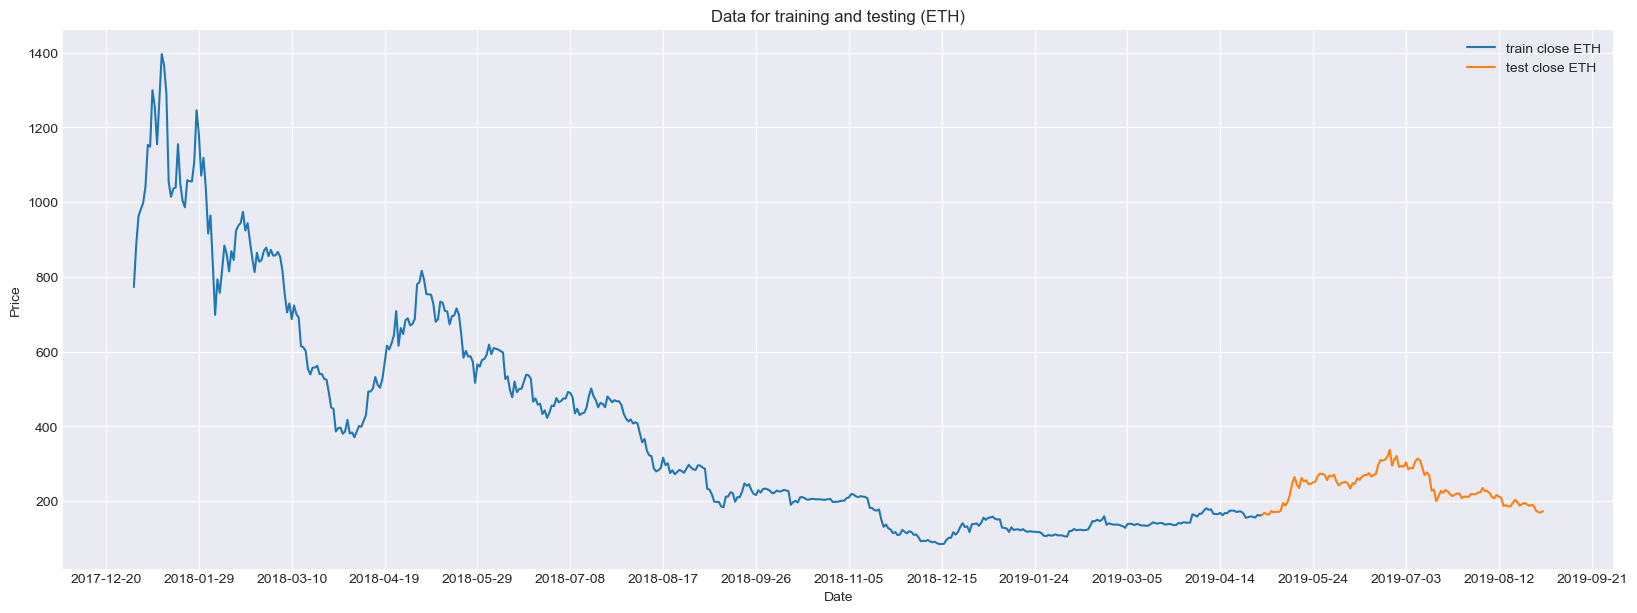

In [72]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(eth_train['Adj_Close'],label='train close ETH') 
plt.plot(eth_test['Adj_Close'],label='test close ETH') 

plt.title('Data for training and testing (ETH)') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

#### 9.3 Scaling the data for training and testing

In [73]:
np.random.seed(0) 
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(eth_adjClose)    

#### 9.4 Reshaping the scaled data for LSTM Network

In [74]:
x_train, y_train = [],[] 
for i in range(80,len(eth_train)):
    x_train.append(scaled_data[i-80:i,0]) 
    y_train.append(scaled_data[i,0]) 
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape 

(407, 80, 1)

#### 9.5 Fitting and Training LSTM Network

In [75]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy']) 
model.fit(x_train,y_train,epochs=13,batch_size=1,verbose=2) 

Epoch 1/13
407/407 - 2s - 5ms/step - accuracy: 0.0025 - loss: 8.4278e-04
Epoch 2/13
407/407 - 0s - 929us/step - accuracy: 0.0025 - loss: 7.8584e-04
Epoch 3/13
407/407 - 0s - 904us/step - accuracy: 0.0025 - loss: 6.6134e-04
Epoch 4/13
407/407 - 0s - 911us/step - accuracy: 0.0025 - loss: 5.1448e-04
Epoch 5/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 5.0442e-04
Epoch 6/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.9746e-04
Epoch 7/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.3692e-04
Epoch 8/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 5.2057e-04
Epoch 9/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.3313e-04
Epoch 10/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.2641e-04
Epoch 11/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.8882e-04
Epoch 12/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 4.6323e-04
Epoch 13/13
407/407 - 0s - 1ms/step - accuracy: 0.0025 - loss: 3.8808e-04


In [76]:
indice = len(eth_adjClose)-len(eth_test)-80   
input_eth = eth_adjClose[indice:].values 
input_eth = input_eth.reshape(-1,1) 
input_eth = scaler.transform(input_eth) 

#### 9.6 Prediction using the trained LSTM model

In [77]:
x_test = [] 
for i in range(80,input_eth.shape[0]):
    x_test.append(input_eth[i-80:i,0]) 
x_test = np.array(x_test) 
print(f'Shape of x_test: ',x_test.shape) 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) 
print(f'Shape of x_test for LSTM: ',x_test.shape) 
close_price_predicted_eth = model.predict(x_test) 
close_price_predicted_eth = scaler.inverse_transform(close_price_predicted_eth) 

Shape of x_test:  (122, 80)
Shape of x_test for LSTM:  (122, 80, 1)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023F9781BF60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


#### 9.7 Evaluating the predictions 

In [78]:
# RMSE for LSTM
rmse_eth = np.sqrt(np.mean(np.power((eth_test['Adj_Close'].values-close_price_predicted_eth),2)))
print(f'RMSE for LSTM : {rmse_eth:.6f}') 

# MAPE for LSTM
mape_eth = np.mean(np.abs(close_price_predicted_eth-eth_test['Adj_Close'].values)/np.abs(eth_test['Adj_Close'].values)) 
print(f'MAPE for LSTM : {mape_eth:.6f}') 

# MPE for LSTM 
mpe_eth = np.mean((close_price_predicted_eth-eth_test['Adj_Close'].values)/eth_test['Adj_Close'].values) 
print(f'MPE for LSTM : {mpe_eth:.6f}')   

RMSE for LSTM : 54.687068
MAPE for LSTM : 0.190202
MPE for LSTM : -0.007603


#### 9.8 Correlation between actual values and predicted via LSTM

In [79]:
btc_test.head() 

,Adj_Close,LSTM_Predictions,MA_Predictions,ANN_Predictions
Date,,,,
2019-05-02,5505.283691,5231.671875,4165.588633,5117.023926
2019-05-03,5768.289551,5288.963867,4168.228540,5152.385742
2019-05-04,5831.167480,5407.646484,4170.071319,5241.443359
2019-05-05,5795.708496,5551.215332,4172.803533,5333.997070
2019-05-06,5746.807129,5673.710938,4175.386206,5408.635742


In [80]:
btc_test['ETH_Predictions'] = close_price_predicted_eth  

corr_ETH = np.corrcoef(btc_test['ETH_Predictions'].dropna().values,eth_test['Adj_Close'].dropna().values)[0,1] 
corr_ETH = round(corr_ETH*100,2) 
print(f'correlation btw test-closing and LSTM-predicted-closing : {corr_ETH}%')  

correlation btw test-closing and LSTM-predicted-closing : 89.76%


#### 9.9 Plotting the predictions from LSTM w.r.t Test values

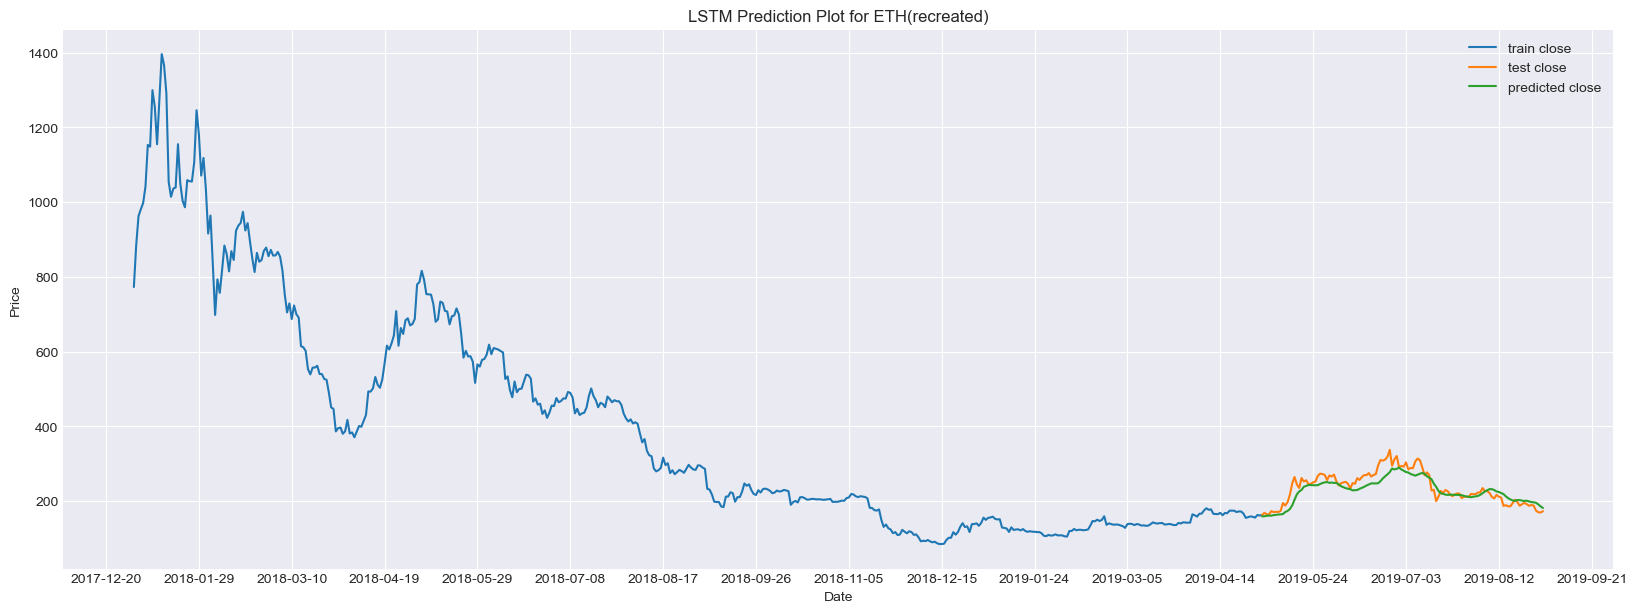

In [81]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(eth_train['Adj_Close'],label='train close') 
plt.plot(eth_test['Adj_Close'],label='test close') 
plt.plot(btc_test['ETH_Predictions'],label='predicted close') 
plt.title('LSTM Prediction Plot for ETH(recreated)') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

## 10. Plotting all 4 models for BTC Predictions

In [82]:
btc_test.head(2)  

,Adj_Close,LSTM_Predictions,MA_Predictions,ANN_Predictions,ETH_Predictions
Date,,,,,
2019-05-02,5505.283691,5231.671875,4165.588633,5117.023926,158.600876
2019-05-03,5768.289551,5288.963867,4168.228540,5152.385742,158.663544


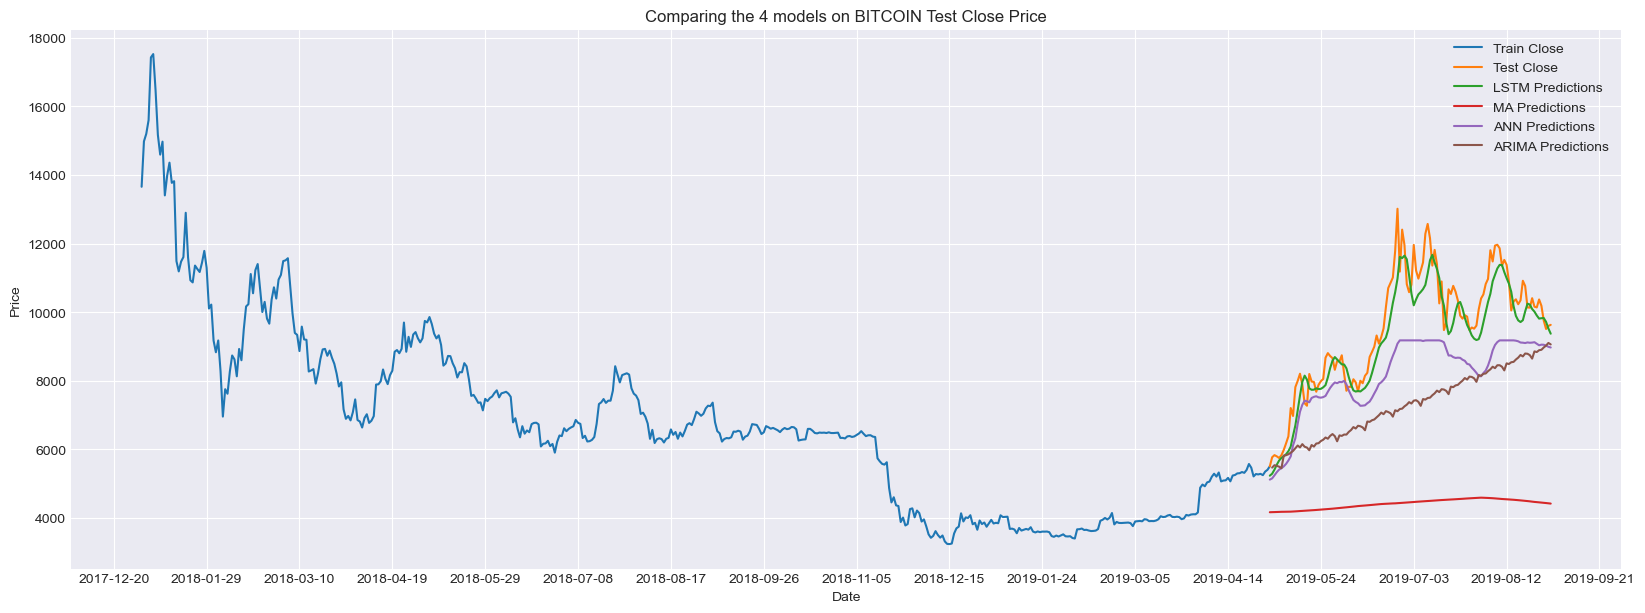

In [83]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.plot(btc_train['Adj_Close'],label='Train Close') 
plt.plot(btc_test['Adj_Close'],label='Test Close') 
plt.plot(btc_test['LSTM_Predictions'],label='LSTM Predictions') 
plt.plot(btc_test['MA_Predictions'],label='MA Predictions') 
plt.plot(btc_test['ANN_Predictions'],label='ANN Predictions') 
plt.plot(btc_arima['ARIMA_Predictions'],label='ARIMA Predictions') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.title('Comparing the 4 models on BITCOIN Test Close Price')
plt.xlabel('Date') 
plt.ylabel('Price') 
ax.grid(True)
plt.legend(loc='best') 
plt.show()  

In [84]:
rmse = [rmse_lstm,rmse_ma,rmse_arima,rmse_ann,rmse_eth] 
mape = [mape_lstm,mape_ma,mape_arima,mape_ann,mape_eth] 
mpe = [mpe_lstm,mpe_ma,mpe_arima,mpe_ann,mpe_eth] 
correln = [corr_LSTM,corr_MA,corr_ARIMA,corr_ANN,corr_ETH] 

model_list = ['LSTM_btc','MA_btc','ARIMA_btc','ANN_btc','LSTM_eth'] 
data={'model':model_list,'rmse':rmse,'mape':mape,'mpe':mpe,'accuracy (%)':correln} 

df_eval = pd.DataFrame(data) 
df_eval 

,model,rmse,mape,mpe,accuracy (%)
0,LSTM_btc,2394.725847,0.212185,-0.000430,95.34
1,MA_btc,5384.391273,0.522660,-0.522660,83.05
2,ARIMA_btc,2550.483250,0.223989,-0.223989,72.18
3,ANN_btc,2469.081378,0.209266,-0.111010,90.73
4,LSTM_eth,54.687068,0.190202,-0.007603,89.76
